In [1]:
import os
from pprint import pprint
import sys

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks, hilbert
import pickle

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader, plotter, misc, performer
from sleeprnn.detection import metrics, det_utils, ensemble
from figs_thesis import fig_utils
from baselines_scripts.butils import get_partitions
from sleeprnn.detection.feeder_dataset import FeederDataset
from sklearn.linear_model import LinearRegression, HuberRegressor
from sleeprnn.data import utils

RESULTS_PATH = os.path.join(project_root, 'results')
BASELINES_PATH = os.path.join(project_root, 'resources', 'comparison_data', 'baselines_2021')

%matplotlib inline
viz.notebook_full_width()

param_filtering_fn = fig_utils.get_filtered_signal_for_event
param_frequency_fn = fig_utils.get_frequency_by_fft
param_amplitude_fn = fig_utils.get_amplitude_event

# Comparación REDv2-Time y REDv2-CWT

Métricas en cada base de datos (5CV): F1-score y mIoU entre ambos REDv2 y entre ellos mismos.

In [ ]:
models = [constants.V2_TIME, constants.V2_CWT1D]
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT'
}
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MASS_KC_NAME, 1): "MASS-SS2-KC",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}

eval_configs = [
    dict(dataset_name=constants.MASS_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_SS_NAME, expert=2, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.INTA_SS_NAME, expert=1, strategy='5cv', seeds=3),
]
metrics_list = []
metrics_raw_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    average_mode = constants.MICRO_AVERAGE if (config["dataset_name"] == constants.MODA_SS_NAME) else constants.MACRO_AVERAGE
    # Collect predictions
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], dataset, config["expert"], verbose=False)
        # Retrieve only predictions, same format as baselines
        pred_dict[model_version] = {s: {} for s in dataset.all_ids}
        for k in range(n_folds):
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            for s, pred in zip(fold_subjects, fold_predictions):
                pred_dict[model_version][s][k] = pred
    # Generate typical dict
    pred_dict_original = {}
    for model_version in models:
        pred_dict_original[model_version] = {}
        for k in range(n_folds):
            pred_dict_original[model_version][k] = {s: pred_dict[model_version][s][k] for s in test_ids_list[k]}
    # Generate surrogate model
    # Random permutation of fold assignments of predictions
    pred_dict_permuted = {}
    for model_version in models:
        pred_dict_permuted[model_version] = {}
        for i_sub, subject_id in enumerate(dataset.all_ids):
            byfold_preds = pred_dict[model_version][subject_id]
            subject_folds = list(byfold_preds.keys())
            subject_preds = [byfold_preds[k] for k in subject_folds]
            subject_folds = np.random.RandomState(seed=i_sub).permutation(subject_folds)
            pred_dict_permuted[model_version][subject_id] = {k: pred for k, pred in zip(subject_folds, subject_preds)}
    pred_dict_permuted_original = {}
    for model_version in models:
        pred_dict_permuted_original[model_version] = {}
        for k in range(n_folds):
            pred_dict_permuted_original[model_version][k] = {s: pred_dict_permuted[model_version][s][k] for s in test_ids_list[k]}
    
    # Performance
    table = {'Comparison': [], 'F1-score': [], 'Recall': [], 'Precision': [], 'mIoU': [], 'Fold': []}
    # Measure performance of model with itself
    for model_version in models:
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            events_list = [pred_dict_original[model_version][k][subject_id] for subject_id in subject_ids]
            detections_list = [pred_dict_permuted_original[model_version][k][subject_id] for subject_id in subject_ids]
            performance = fig_utils.compute_fold_performance(events_list, detections_list, average_mode)
            table['Comparison'].append('%s_vs_%s' % (model_version, model_version))
            table['F1-score'].append(performance['F1-score'])
            table['Recall'].append(performance['Recall'])
            table['Precision'].append(performance['Precision'])
            table['mIoU'].append(performance['mIoU'])
            table['Fold'].append(k)
    # Measure performance of time vs cwt
    for k in range(n_folds):
        subject_ids = test_ids_list[k]
        events_list = [pred_dict_original[models[0]][k][subject_id] for subject_id in subject_ids]
        detections_list = [pred_dict_original[models[1]][k][subject_id] for subject_id in subject_ids]
        performance = fig_utils.compute_fold_performance(events_list, detections_list, average_mode)
        table['Comparison'].append('%s_vs_%s' % (models[0], models[1]))
        table['F1-score'].append(performance['F1-score'])
        table['Recall'].append(performance['Recall'])
        table['Precision'].append(performance['Precision'])
        table['mIoU'].append(performance['mIoU'])
        table['Fold'].append(k)
    
    table = pd.DataFrame.from_dict(table)
    metrics_raw_list.append(table)
    mean_table = table.groupby(by=["Comparison"]).mean()[["F1-score", "mIoU"]].add_suffix("_mean")
    std_table = table.groupby(by=["Comparison"]).std(ddof=0)[["F1-score", "mIoU"]].add_suffix("_std")
    subgroup_stats_table = mean_table.join(std_table)
    subgroup_stats_table = subgroup_stats_table.reindex(sorted(subgroup_stats_table.columns), axis=1)
    subgroup_stats_table = subgroup_stats_table.reset_index()
    metrics_list.append(subgroup_stats_table)  
print("Done.")

In [ ]:
# Tabla Latex
comparisons_order = ["v2_time_vs_v2_time", "v2_cwt1d_vs_v2_cwt1d", "v2_time_vs_v2_cwt1d"]
comparisons_print_name = {
    "v2_time_vs_v2_time": "REDv2-Time vs REDv2-Time", 
    "v2_cwt1d_vs_v2_cwt1d": "REDv2-CWT vs REDv2-CWT", 
    "v2_time_vs_v2_cwt1d": "REDv2-Time vs REDv2-CWT"
}

print("Datos & Comparación & F1-score (%) & mIoU (%) \\\\")
for i_config, config in enumerate(eval_configs):
    print("")
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    metrics_dict = metrics_list[i_config].set_index('Comparison').to_dict('index')
    for comparison in comparisons_order:
        mets = metrics_dict[comparison]
        metric_str = "$%1.1f\pm %1.1f$ & $%1.1f\pm %1.1f$" % (
            100 * mets['F1-score_mean'], 100 * mets['F1-score_std'],
            100 * mets['mIoU_mean'], 100 * mets['mIoU_std'])
        row_str = "%s & %s & %s \\\\" % (dataset_str, comparisons_print_name[comparison], metric_str)
        print(row_str)
        
    # Statistical tests
    reference_comparison = comparisons_order[-1]
    print("P-value test against %s" % reference_comparison)
    table = metrics_raw_list[i_config]
    for comparison in comparisons_order[:-1]:
        print("%s:" % comparison.ljust(30), end='')
        for metric_name in ["F1-score", "mIoU"]:
            model_metrics = table[table["Comparison"] == comparison][metric_name].values
            reference_metrics = table[table["Comparison"] == reference_comparison][metric_name].values
            pvalue = stats.ttest_ind(model_metrics, reference_metrics, equal_var=False)[1]
            print(" P(%s) %1.4f" % (metric_name, pvalue), end='')
        print("")

# Ensamble de RED

Desempeño al ensamblar las detecciones de ambos modelos (y ensambles de un modelo consigo mismo haciendo el truco de la permutacion) con un AND, con un OR, o al promediar las probabilidades ajustadas antes de aplicar el umbral. Esto para ver si las pequeñas diferencias que tienen ayudan o no.

In [ ]:
models = [constants.V2_TIME, constants.V2_CWT1D]
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT'
}
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MASS_KC_NAME, 1): "MASS-SS2-KC",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}

eval_configs = [
    dict(dataset_name=constants.MASS_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_SS_NAME, expert=2, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.INTA_SS_NAME, expert=1, strategy='5cv', seeds=3),
]
ensemble_criterion_list = [
    'and', 
    # 'or', 
    'avg'
]

metrics_list = []
metrics_raw_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    average_mode = constants.MICRO_AVERAGE if (config["dataset_name"] == constants.MODA_SS_NAME) else constants.MACRO_AVERAGE
    # Collect predictions
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions(
            model_version, config["strategy"], dataset, config["expert"], verbose=False)
        # Retrieve probas and stamps
        pred_dict[model_version] = {s: {} for s in dataset.all_ids}
        for k in range(n_folds):
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_probas = tmp_dict[k][constants.TEST_SUBSET].get_probabilities(return_adjusted=True)
            fold_stamps = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            for s, proba, stamp in zip(fold_subjects, fold_probas, fold_stamps):
                pred_dict[model_version][s][k] = {'probability': proba, 'stamp': stamp} 
    # Generate typical dict
    pred_dict_original = {}
    for model_version in models:
        pred_dict_original[model_version] = {}
        for k in range(n_folds):
            pred_dict_original[model_version][k] = {s: pred_dict[model_version][s][k] for s in test_ids_list[k]}
    # Generate surrogate model
    # Random permutation of fold assignments of predictions
    pred_dict_permuted = {}
    for model_version in models:
        pred_dict_permuted[model_version] = {}
        for i_sub, subject_id in enumerate(dataset.all_ids):
            byfold_preds = pred_dict[model_version][subject_id]
            subject_folds = list(byfold_preds.keys())
            subject_preds = [byfold_preds[k] for k in subject_folds]
            subject_folds = np.random.RandomState(seed=i_sub).permutation(subject_folds)
            pred_dict_permuted[model_version][subject_id] = {k: pred for k, pred in zip(subject_folds, subject_preds)}
    pred_dict_permuted_original = {}
    for model_version in models:
        pred_dict_permuted_original[model_version] = {}
        for k in range(n_folds):
            pred_dict_permuted_original[model_version][k] = {s: pred_dict_permuted[model_version][s][k] for s in test_ids_list[k]}
            
    # Performance
    # AND: ensemble of stamps -> thr = 1.0
    # OR: ensemble of stamps -> thr = 1 / n_models
    # AVG: ensemble of probas with thr of 0.5
    table = {'Ensemble': [], 'F1-score': [], 'Recall': [], 'Precision': [], 'mIoU': [], 'Fold': []}
    pred_sources = {
        'v2_time': pred_dict_original['v2_time'],
        'v2_time_perm': pred_dict_permuted_original['v2_time'],
        'v2_cwt1d': pred_dict_original['v2_cwt1d'],
        'v2_cwt1d_perm': pred_dict_permuted_original['v2_cwt1d'],
    }
    pairs = [
        ('v2_time', 'v2_time'),
        ('v2_cwt1d', 'v2_cwt1d'),
        ('v2_time', 'v2_time_perm'),
        ('v2_cwt1d', 'v2_cwt1d_perm'),
        ('v2_time', 'v2_cwt1d'),
    ]
    for k in range(n_folds):
        subject_ids = test_ids_list[k]
        print("Fold %s" % (k))
        reference_feeder_dataset = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
        events_list = reference_feeder_dataset.get_stamps()
        for pred_source_name_1, pred_source_name_2 in pairs:
            pred_source_1 = pred_sources[pred_source_name_1]
            pred_source_2 = pred_sources[pred_source_name_2]
            if pred_source_name_1 == pred_source_name_2:
                detections_list = [pred_source_1[k][subject_id]['stamp'] for subject_id in subject_ids]
                performance = fig_utils.compute_fold_performance(events_list, detections_list, average_mode)
                ensemble_str = pred_source_name_1
                table['Ensemble'].append(ensemble_str)
                table['F1-score'].append(performance['F1-score'])
                table['Recall'].append(performance['Recall'])
                table['Precision'].append(performance['Precision'])
                table['mIoU'].append(performance['mIoU'])
                table['Fold'].append(k)
            else:
                for criterion in ensemble_criterion_list:
                    if criterion == 'and':
                        dict_of_stamps = {s: [pred_source_1[k][s]['stamp'], pred_source_2[k][s]['stamp']] for s in subject_ids}
                        ensemble_pred_obj = ensemble.generate_ensemble_from_stamps(dict_of_stamps, reference_feeder_dataset, skip_setting_threshold=True)
                        ensemble_pred_obj.set_parent_dataset(dataset)
                        ensemble_pred_obj.set_probability_threshold(1.0)
                    elif criterion == 'or':
                        dict_of_stamps = {s: [pred_source_1[k][s]['stamp'], pred_source_2[k][s]['stamp']] for s in subject_ids}
                        ensemble_pred_obj = ensemble.generate_ensemble_from_stamps(dict_of_stamps, reference_feeder_dataset, skip_setting_threshold=True)
                        ensemble_pred_obj.set_parent_dataset(dataset)
                        ensemble_pred_obj.set_probability_threshold(0.5)
                    elif criterion == 'avg':
                        dict_of_probas = {s: [pred_source_1[k][s]['probability'], pred_source_2[k][s]['probability']] for s in subject_ids}
                        ensemble_pred_obj = ensemble.generate_ensemble_from_probabilities(dict_of_probas, reference_feeder_dataset, skip_setting_threshold=True)
                        ensemble_pred_obj.set_parent_dataset(dataset)
                        ensemble_pred_obj.set_probability_threshold(0.5)
                    else:
                        raise ValueError()
                    detections_list = ensemble_pred_obj.get_stamps()
                    performance = fig_utils.compute_fold_performance(events_list, detections_list, average_mode)
                    ensemble_str = '%s(%s,%s)' % (criterion, pred_source_name_1, pred_source_name_2)
                    table['Ensemble'].append(ensemble_str)
                    table['F1-score'].append(performance['F1-score'])
                    table['Recall'].append(performance['Recall'])
                    table['Precision'].append(performance['Precision'])
                    table['mIoU'].append(performance['mIoU'])
                    table['Fold'].append(k)
    table = pd.DataFrame.from_dict(table)
    metrics_raw_list.append(table)
    mean_table = table.groupby(by=["Ensemble"]).mean().drop(columns=["Fold"]).add_suffix("_mean")
    std_table = table.groupby(by=["Ensemble"]).std(ddof=0).drop(columns=["Fold"]).add_suffix("_std")
    subgroup_stats_table = mean_table.join(std_table)
    subgroup_stats_table = subgroup_stats_table.reindex(sorted(subgroup_stats_table.columns), axis=1)
    subgroup_stats_table = subgroup_stats_table.reset_index()
    metrics_list.append(subgroup_stats_table)  
print("Done.")

In [ ]:
# Tabla Latex
ensembles_order = [
    "v2_time", 
    "v2_cwt1d",
    "and(v2_time,v2_time_perm)",
    "and(v2_cwt1d,v2_cwt1d_perm)",
    "and(v2_time,v2_cwt1d)",
    "avg(v2_time,v2_time_perm)",
    "avg(v2_cwt1d,v2_cwt1d_perm)",
    "avg(v2_time,v2_cwt1d)",
]
ensembles_print_name = {
    "v2_time": "REDv2-Time", 
    "v2_cwt1d": "REDv2-CWT",
    "and(v2_time,v2_time_perm)": "AND(REDv2-Time, REDv2-Time)",
    "and(v2_cwt1d,v2_cwt1d_perm)": "AND(REDv2-CWT, REDv2-CWT)",
    "and(v2_time,v2_cwt1d)": "AND(REDv2-Time, REDv2-CWT)",
    "avg(v2_time,v2_time_perm)": "AVG(REDv2-Time, REDv2-Time)",
    "avg(v2_cwt1d,v2_cwt1d_perm)": "AVG(REDv2-CWT, REDv2-CWT)",
    "avg(v2_time,v2_cwt1d)": "AVG(REDv2-Time, REDv2-CWT)",
}
print("\\toprule")
print("Datos & Detector & F1-score (\%) & mIoU (\%) \\\\")
for i_config, config in enumerate(eval_configs):
    print("\midrule")
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    metrics_dict = metrics_list[i_config].set_index('Ensemble').to_dict('index')
    for i_ens, ensemble in enumerate(ensembles_order):
        mets = metrics_dict[ensemble]
        metric_str = "$%1.1f\pm %1.1f$ & $%1.1f\pm %1.1f$" % (
            100 * mets['F1-score_mean'], 100 * mets['F1-score_std'],
            100 * mets['mIoU_mean'], 100 * mets['mIoU_std'])
        dataset_to_print = '%s\n' % dataset_str if (i_ens == 0) else ''
        row_str = "%s & %s & %s \\\\" % (dataset_to_print, ensembles_print_name[ensemble].ljust(30), metric_str)
        print(row_str)
        
    # Statistical tests
    #reference_ensemble = ensembles_order[0]
    #print("P-value test against %s" % reference_ensemble)
    #table = metrics_raw_list[i_config]
    #for ensemble in ensembles_order[1:]:
    #    print("%s:" % ensemble.ljust(50), end='')
    #    for metric_name in ["F1-score", "mIoU"]:
    #        model_metrics = table[table["Ensemble"] == ensemble][metric_name].values
    #        reference_metrics = table[table["Ensemble"] == reference_ensemble][metric_name].values
    #        pvalue = stats.ttest_ind(model_metrics, reference_metrics, equal_var=False)[1]
    #        print(" P(%s) %1.4f" % (metric_name, pvalue), end='')
    #    print("")
print("\\bottomrule")

# Perturbaciones en la entrada
Medir cambios en SubsetMetric vs perturbacion, donde subset metric es la metrica mean+-std del 5CV del dataset, y puede ser f1-score, recall, precision y mIoU (lo bueno es que las 4 están en el rango 0-1).
- Escalar la señal de entrada. Curva continua
- Inversión de voltaje (multiplicar por -1) y de tiempo (flipped signal y labels, para implementarlo se podria hacer flip de la entrada, y el vector de probabilidad de salida volver a hacerle un flip). Discreto (barras).
- Filtrar (quitar) bandas de potencia (modelado ya entrenado). Delta separarlo en delta lenta y rapida. Discreto (barras).

In [ ]:
models = [constants.V2_TIME, constants.V2_CWT1D]
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT'
}
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MASS_KC_NAME, 1): "MASS-SS2-KC",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}

eval_configs = [
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
]
metrics_list = []
metrics_raw_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    average_mode = constants.MICRO_AVERAGE if (config["dataset_name"] == constants.MODA_SS_NAME) else constants.MACRO_AVERAGE
    # Collect predictions
    pred_dict = {}
    for model_version in models:
        pred_dict[model_version] = {}
        tmp_pert_dict = fig_utils.get_red_predictions_for_perturbations(model_version, config["strategy"], dataset, config["expert"], verbose=False)
        perturbations = list(tmp_pert_dict.keys())
        for perturbation_name in perturbations:
            pred_dict[model_version][perturbation_name] = {}
            tmp_dict = tmp_pert_dict[perturbation_name]
            for k in tmp_dict.keys():
                fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
                fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
                pred_dict[model_version][perturbation_name][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}

    # Performance
    table = {'Detector': [], 'Perturbación': [], 'F1-score': [], 'Recall': [], 'Precision': [], 'mIoU': [], 'Fold': []}
    # Measure performance of model with itself
    for model_version in models:
        for perturbation_name in perturbations:
            for k in range(n_folds):
                subject_ids = test_ids_list[k]
                feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
                events_list = feed_d.get_stamps()
                detections_list = [pred_dict[model_version][perturbation_name][k][subject_id] for subject_id in subject_ids]
                performance = fig_utils.compute_fold_performance(events_list, detections_list, average_mode)
                table['Detector'].append(model_version)
                table['Perturbación'].append(perturbation_name)
                table['F1-score'].append(performance['F1-score'])
                table['Recall'].append(performance['Recall'])
                table['Precision'].append(performance['Precision'])
                table['mIoU'].append(performance['mIoU'])
                table['Fold'].append(k)
    table = pd.DataFrame.from_dict(table)
    print("By-fold statistics")
    metrics_raw_list.append(table)
    mean_table = table.groupby(by=["Detector", "Perturbación"]).mean().drop(columns=["Fold"]).add_suffix("_mean")
    std_table = table.groupby(by=["Detector", "Perturbación"]).std(ddof=0).drop(columns=["Fold"]).add_suffix("_std")
    subgroup_stats_table = mean_table.join(std_table)
    subgroup_stats_table = subgroup_stats_table.reindex(sorted(subgroup_stats_table.columns), axis=1)
    subgroup_stats_table = subgroup_stats_table.reset_index()
    metrics_list.append(subgroup_stats_table)  
print("Done.")

In [ ]:
# Generate table for latex
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
}
ref_order = [constants.V2_TIME, constants.V2_CWT1D]
pert_prefix_order = ['scale', 'invert', 'filter']
pert_labels = {
    'scale': 'Factor de escala',
    'invert': 'Inversión',
    'filter': 'Filtro rechaza-banda',
}
pert_sorted_values = {
    'scale': np.round(np.arange(0.5, 1.5 + 0.001, 0.1), 1),
    'invert': ['value', 'time'],
    'filter': [(0, 2), (2, 4), (4, 8), (8, 11), (10, 16), (16, 30)]
}
pert_names_table = {
    'scale': {x: '%1.1f' % x for x in pert_sorted_values['scale']},
    'invert': {x: x for x in pert_sorted_values['invert']},
    'filter': {b: '%d-%d' % (b[0], b[1]) for b in pert_sorted_values['filter']}
}
pert_names_print = {
    'scale': {x: '%1.1f' % x for x in pert_sorted_values['scale']},
    'invert': {'time': 'Tiempo', 'value': 'Amplitud'},
    'filter': {b: '%d-%d Hz' % (b[0], b[1]) for b in pert_sorted_values['filter']}
}
print("Datos & Perturbación & Valor & %s \\\\" % " & ".join([print_model_names[model_name] for model_name in ref_order]))
for i_config, config in enumerate(eval_configs):
    dataset_str = print_dataset_names[(config['dataset_name'], config['expert'])]
    table = metrics_list[i_config]
    model_names = [m for m in ref_order if m in np.unique(table['Detector'])]
    n_models = len(model_names)
    table = table[['Detector', 'Perturbación', 'F1-score_mean', 'F1-score_std']]
    perturbations = np.unique(table['Perturbación'])
    print("\n%s" % dataset_str)
    for pert_prefix in pert_prefix_order:      
        print("& %s" % pert_labels[pert_prefix])
        for pert_value in pert_sorted_values[pert_prefix]:
            metric_str_list = []
            pert_name_table = '%s-%s' % (pert_prefix, pert_names_table[pert_prefix][pert_value])
            for model_name in model_names:
                model_table = table[(table['Detector'] == model_name) & (np.isin(table['Perturbación'], pert_name_table))].drop(columns=['Detector'])
                model_table = model_table.set_index('Perturbación')
                metrics_dict = model_table.to_dict('index')
                metric_str = '$%1.1f\pm %1.1f$' % (
                    100 * metrics_dict[pert_name_table]['F1-score_mean'], 100 * metrics_dict[pert_name_table]['F1-score_std'])
                metric_str_list.append(metric_str)
            metric_str = " & ".join(metric_str_list)
            pert_name_to_print = pert_names_print[pert_prefix][pert_value]
            metric_str = " & & %s & %s \\\\" % (pert_name_to_print, metric_str)
            print(metric_str)

In [ ]:
# Figure

save_figure = True
markersize = 4
number_of_std = 1
groups_total_width = 0.5

letters = ['A', 'B', 'C', 'D', 'E', 'F']
baseline_color = viz.GREY_COLORS[8]
model_specs = {
    constants.V2_TIME: dict(marker='o', color=viz.PALETTE['blue']),
    constants.V2_CWT1D: dict(marker='o', color=viz.PALETTE['red']),
}
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
}
ref_order = [constants.V2_TIME, constants.V2_CWT1D]
pert_prefix_order = ['scale', 'invert', 'filter']
pert_labels = {
    'scale': 'Factor de escala',
    'invert': 'Inversión',
    'filter': 'Filtro rechaza-banda (Hz)',
}
pert_sorted_values = {
    'scale': np.round(np.arange(0.5, 1.5 + 0.001, 0.1), 1),
    'invert': ['none', 'value', 'time'],
    'filter': [(0, 2), (2, 4), (4, 8), (8, 11), (10, 16), (16, 30)]
}
pert_names_table = {
    'scale': {x: '%1.1f' % x for x in pert_sorted_values['scale']},
    'invert': {x: x for x in pert_sorted_values['invert']},
    'filter': {b: '%d-%d' % (b[0], b[1]) for b in pert_sorted_values['filter']}
}
pert_names_print = {
    'scale': {x: '%1.1f' % x for x in pert_sorted_values['scale']},
    'invert': {'none': 'Ninguna', 'time': 'Tiempo', 'value': 'Amplitud'},
    'filter': {b: '%d-%d' % (b[0], b[1]) for b in pert_sorted_values['filter']}
}
metrics_sorted = ['F1-score', 'Recall', 'Precision', 'mIoU']

fig, axes = plt.subplots(2, 3, figsize=(8, 9), dpi=200)
axes = np.concatenate([axes[:1, :], axes[1:, :]], axis=1) 
axes = axes.flatten()

ax_loc = -1  # global loc
for i_config, config in enumerate(eval_configs):
    table = metrics_list[i_config]
    model_names = [m for m in ref_order if m in np.unique(table['Detector'])]
    for model_name in model_names:
        original_perf_row = table[(table['Detector'] == model_name) & (table['Perturbación'] == 'scale-1.0')].to_dict(orient='records')[0]
        original_perf_row['Perturbación'] = 'invert-none'
        table = table.append(original_perf_row, ignore_index=True)
    n_models = len(model_names)
    for pert_prefix in pert_prefix_order:
        ax_loc += 1
        ax = axes[ax_loc]
        pert_values = pert_sorted_values[pert_prefix]
        pert_table = ['%s-%s' % (pert_prefix, pert_names_table[pert_prefix][pert_value]) for pert_value in pert_values]
    
        n_groups = len(pert_values)
        positions = np.arange(n_groups)
        groups_width = groups_total_width / n_models
        initial_group_center_offset = groups_width * (1 - n_models) / 2
        offsets = initial_group_center_offset + np.arange(n_models) * groups_width
        distance_from_edge = groups_total_width / 2 + 0.05

        for j, model_name in enumerate(model_names):
            
            model_table = table[(table['Detector'] == model_name) & (np.isin(table['Perturbación'], pert_table))].drop(columns=['Detector'])
            model_table = model_table.set_index('Perturbación')
            metrics_dict = model_table.to_dict('index')
            
            metric_lims = []
            for i, metric_name in enumerate(metrics_sorted):
                offset = - 1.2 * i
                metric_lims.append([offset, offset + 1])
                # Margins
                ax.axhline(offset, linewidth=0.8, color="k")
                ax.axhline(offset + 1, linewidth=0.8, color="k")
                ax.plot(
                    [positions[0]-distance_from_edge, positions[0]-distance_from_edge], 
                    [offset + 0.01, offset + 1 - 0.01], linewidth=1.6, color="k")
                ax.plot(
                    [positions[-1]+distance_from_edge, positions[-1]+distance_from_edge], 
                    [offset + 0.01, offset + 1 - 0.01], linewidth=1.6, color="k")
                if pert_prefix == 'scale':
                    center_pos = n_groups // 2
                    ax.plot(
                        [positions[center_pos], positions[center_pos]], 
                        [offset + 0.01, offset + 1 - 0.01], linewidth=1.1, color="k", zorder=10, linestyle="--")
                # Data
                mean_data = offset + np.array([metrics_dict[pert_name_table]['%s_mean' % metric_name] for pert_name_table in pert_table])
                std_data = np.array([metrics_dict[pert_name_table]['%s_std' % metric_name] for pert_name_table in pert_table])
                this_positions = positions + offsets[j]
                ax.plot(
                    this_positions, mean_data, label=print_model_names[model_name], linestyle="None",
                    marker=model_specs[model_name]["marker"], markersize=markersize, markeredgewidth=0.0,
                    color=model_specs[model_name]["color"], zorder=30)
                for i_sg in range(n_groups):
                    ax.plot(
                        [this_positions[i_sg], this_positions[i_sg]],
                        [
                            mean_data[i_sg] - number_of_std*std_data[i_sg], 
                            mean_data[i_sg] + number_of_std*std_data[i_sg]
                        ],
                        linewidth=1, color=model_specs[model_name]["color"], zorder=20
                    )
        
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([positions[0] - distance_from_edge, positions[-1] + distance_from_edge])
        ax.set_ylim([offset, 1])
        yticks = np.concatenate([[m[0], (m[0]+m[1])/2, m[1]] for m in metric_lims])
        yticklabels = np.concatenate([[0, n, 1] for n in metrics_sorted])
        yticks_minor = np.concatenate([np.arange(m[0], m[1]+0.001, 0.1) for m in metric_lims])
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        ax.set_yticks(yticks_minor, minor=True)
        for i_tick, t in enumerate(ax.get_yticklabels()):
            if i_tick % 3 == 1:
                t.set_rotation('vertical')
                t.set_verticalalignment('center')
        ax.grid(axis="y", which="minor")
        ax.yaxis.labelpad = -8
        ax.tick_params(labelsize=8)
        ax.set_xticks([i for i in range(n_groups)])
        ax.set_xticklabels([])
        ax.set_xticklabels([pert_names_print[pert_prefix][pert_value] for pert_value in pert_values])
        ax.set_xlabel(pert_labels[pert_prefix], fontsize=8)
        dataset_str = print_dataset_names[(config['dataset_name'], config['expert'])]
        ax.set_title("Perturbación en %s" % dataset_str, loc="center", fontsize=8)   
        ax.text(
            x=-0.01, y=1.02, fontsize=16, s=r"$\bf{%s}$" % letters[ax_loc],
            ha="left", transform=ax.transAxes)
        
plt.tight_layout()

# Get legend methods
labels_to_lines_dict = {}
for ax in axes:
    t_lines, t_labels = ax.get_legend_handles_labels()
    for lbl, lin in zip(t_labels, t_lines):
        labels_to_lines_dict[lbl] = lin
labels = ["REDv2-Time", "REDv2-CWT"]
lines = [labels_to_lines_dict[lbl] for lbl in labels]
lg1 = fig.legend(
    lines, labels, fontsize=8, loc="lower center",
    bbox_to_anchor=(0.5, 0.01), ncol=len(labels), frameon=False, handletextpad=0.5)

if save_figure:
    # Save figure
    fname_prefix = "result_indata_perturbations"
    plt.savefig("%s.pdf" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)

plt.show()

# PINK

Respuesta del modelo ya entrenado ante ruido rosado , incluyendo qué pasa si el ruido rosado cambia su desviacion estandar (escalamiento de 1 a 2 con paso 0.5). Medir tasa promedio de falsos por horas de la señal, y visualizar detecciones en caso de haber, y ver qué tan estable es dicha deteccion (si la predicen varios checkpoints o no). 

Todos los checkpoints predicen todo pink.

Ideas:
- Numero de detecciones por minuto u hora vs escala.
- Probabilidad asignada a las detecciones vs escala.
- Para la escala 1.0: Distribucion de amplitud, duracion, y frecuencia si es SS.
- Visualización de algunas detecciones con amplitud creciente, mostrando los vectores de probabilidad ajustada de todos los folds.
- Grand-average de "complejo K" alineado con el peak negativo (minimo valor dentro de la marca).

### PINK: Tabla de Stats

In [3]:
models = [constants.V2_TIME, constants.V2_CWT1D]
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT'
}
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MASS_KC_NAME, 1): "MASS-SS2-KC",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}

eval_configs = [
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
]

In [ ]:
# Collect predictions
stats_list = []
for config in eval_configs:
    print("\nLoading", config)
    source_dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    pink = reader.load_dataset(constants.PINK_NAME, verbose=False)
    pink.event_name = source_dataset.event_name
    _, _, test_ids_list = get_partitions(source_dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    pred_dict = {}
    table = []
    for model_version in models:
        pred_dict[model_version] = {}
        tmp_pert_dict = fig_utils.get_red_predictions_for_pink(
            model_version, config["strategy"], source_dataset, config["expert"], 
            pink_dataset=pink, verbose=False)
        perturbations = list(tmp_pert_dict.keys())
        for perturbation_name in perturbations:
            pred_dict[model_version][perturbation_name] = {}
            tmp_dict = tmp_pert_dict[perturbation_name]
            for k in tmp_dict.keys():
                fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
                fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
                pred_dict[model_version][perturbation_name][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
                for subject_id in pink.all_ids:
                    this_pred = pred_dict[model_version][perturbation_name][k][subject_id]
                    table.append(
                        {'model': model_version, 'scale': perturbation_name, 'fold': k, 'subject_id': subject_id, 'n_events': this_pred.shape[0]}
                    )
    table = pd.DataFrame(table)
    stats_list.append(table)
print("Done.")

pink = reader.load_dataset(constants.PINK_NAME, verbose=False)

# Table of stats
total_n2_hours = np.concatenate(pink.get_pages(pages_subset=constants.N2_RECORD)).size * pink.page_duration / 3600

print("Datos & Factor de escala & Detector & Detecciones & Densidad (eph) \\\\")
for i_config, config in enumerate(eval_configs):
    table = stats_list[i_config]
    agg_table = table.drop(columns=["subject_id"]).groupby(by=["model", "scale", "fold"]).sum()
    agg_table = agg_table.reset_index()
    agg_table_mean = agg_table.drop(columns=["fold"]).groupby(by=["model", "scale"]).mean().add_suffix("_mean")
    agg_table_std = agg_table.drop(columns=["fold"]).groupby(by=["model", "scale"]).std(ddof=0).add_suffix("_std")
    agg_table = agg_table_mean.join(agg_table_std)
    agg_table_density = (agg_table / total_n2_hours).add_suffix("_per_hour")
    agg_table = agg_table.join(agg_table_density)
    agg_table = agg_table.reset_index()
    agg_table = agg_table.to_dict()
    
    dataset_str = print_dataset_names[(config['dataset_name'], config['expert'])]
    print("\n%s" % dataset_str)
    rows_list = []
    for j in range(len(agg_table['model'])):
        row_str = "& %s & %s & $%1.1f \pm %1.1f$ & $%1.1f \pm %1.1f$ \\\\" % (
            agg_table['scale'][j].split("-")[-1],
            print_model_names[agg_table['model'][j]],
            agg_table['n_events_mean'][j],
            agg_table['n_events_std'][j],
            agg_table['n_events_mean_per_hour'][j],
            agg_table['n_events_std_per_hour'][j],
        )
        rows_list.append(row_str)
    rows_list = np.sort(rows_list)
    for row in rows_list:
        print(row)

### PINK: Boxplot params

In [ ]:
# boxplots de parametros 1: probability of detections
eval_configs = [
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
]


metrics_list = []
for config in eval_configs:
    
    stat_spindle = (config["dataset_name"] == constants.MODA_SS_NAME)
    chosen_scale = 'scale-2.0' if stat_spindle else 'scale-1.0'
    
    print("\nLoading", config)
    source_dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    
    # source stuff
    pred_dict = {}
    pred_proba_dict = {}
    for model_version in models:
        pred_dict[model_version] = {}
        pred_proba_dict[model_version] = {}
        tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], source_dataset, config["expert"], verbose=False)
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            fold_probas = tmp_dict[k][constants.TEST_SUBSET].get_stamps_probabilities()
            pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
            pred_proba_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_probas)}
    source_pred_dict = pred_dict
    source_pred_proba_dict = pred_proba_dict
    
    # Pink stuff
    pink = reader.load_dataset(constants.PINK_NAME, verbose=False)
    pink.event_name = source_dataset.event_name
    
    pred_dict = {}
    pred_proba_dict = {}
    for model_version in models:
        pred_dict[model_version] = {}
        pred_proba_dict[model_version] = {}
        tmp_pert_dict = fig_utils.get_red_predictions_for_pink(
            model_version, config["strategy"], source_dataset, config["expert"], 
            pink_dataset=pink, verbose=False)
        perturbation_name = chosen_scale
        tmp_dict = tmp_pert_dict[perturbation_name]
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            fold_probas = tmp_dict[k][constants.TEST_SUBSET].get_stamps_probabilities()
            pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
            pred_proba_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_probas)}
    pink_pred_dict = pred_dict
    pink_pred_proba_dict = pred_proba_dict
    
    # Retrieve parameters, all events together
    table = {
        'Dataset': [],
        'Detector': [],
        'Proba': [],
        'Duration': [], 
        'AmplitudePP': [],
        'Frequency': [],
    }
    
    # from source dataset detections
    _, _, test_ids_list = get_partitions(source_dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    for model_name in models:
        tmp_table = {
            'Proba': [],
            'Duration': [], 
            'AmplitudePP': [],
            'Frequency': [],
        }
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            feed_d = FeederDataset(source_dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            detections_list = [source_pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            probas_list = [source_pred_proba_dict[model_name][k][subject_id] for subject_id in subject_ids]
            for i_sub, subject_id in enumerate(subject_ids):
                detections = detections_list[i_sub]
                if detections.size == 0:
                    continue
                # Duration
                duration = (detections[:, 1] - detections[:, 0] + 1) / source_dataset.fs
                tmp_table['Duration'].append(duration)
                # Amplitude
                signal = source_dataset.get_subject_signal(subject_id, normalize_clip=False)
                event_name = 'spindle' if stat_spindle else 'kcomplex'
                filt_signal = param_filtering_fn(signal, source_dataset.fs, event_name)
                signal_events = [filt_signal[e[0]:e[1]+1] for e in detections]
                amplitude = np.array([param_amplitude_fn(s, source_dataset.fs, event_name) for s in signal_events])
                tmp_table['AmplitudePP'].append(amplitude)
                # Frequency
                if stat_spindle:
                    freq_central = np.array([param_frequency_fn(s, source_dataset.fs) for s in signal_events])
                else:
                    freq_central = np.array([1] * len(signal_events))
                tmp_table['Frequency'].append(freq_central) 
                # Proba
                tmp_table['Proba'].append(probas_list[i_sub])
        table['Detector'].append(model_name)
        table['Dataset'].append('Source')
        for key in tmp_table.keys():
            table[key].append(np.concatenate(tmp_table[key]))
    
    # from pink detections
    for model_name in models:
        tmp_table = {
            'Proba': [],
            'Duration': [], 
            'AmplitudePP': [],
            'Frequency': [],
        }
        for k in range(n_folds):
            subject_ids = pink.all_ids
            feed_d = FeederDataset(pink, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            detections_list = [pink_pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            probas_list = [pink_pred_proba_dict[model_name][k][subject_id] for subject_id in subject_ids]
            for i_sub, subject_id in enumerate(subject_ids):
                detections = detections_list[i_sub]
                if detections.size == 0:
                    continue
                # Duration
                duration = (detections[:, 1] - detections[:, 0] + 1) / pink.fs
                tmp_table['Duration'].append(duration)
                # Amplitude
                signal = pink.get_subject_signal(subject_id, normalize_clip=False)
                event_name = 'spindle' if stat_spindle else 'kcomplex'
                filt_signal = param_filtering_fn(signal, pink.fs, event_name)
                signal_events = [filt_signal[e[0]:e[1]+1] for e in detections]
                amplitude = np.array([param_amplitude_fn(s, pink.fs, event_name) for s in signal_events])
                tmp_table['AmplitudePP'].append(amplitude)
                # Frequency
                if stat_spindle:
                    freq_central = np.array([param_frequency_fn(s, pink.fs) for s in signal_events])
                else:
                    freq_central = np.array([1] * len(signal_events))
                tmp_table['Frequency'].append(freq_central) 
                # Proba
                tmp_table['Proba'].append(probas_list[i_sub])
        table['Detector'].append(model_name)
        table['Dataset'].append('Pink')
        for key in tmp_table.keys():
            table[key].append(np.concatenate(tmp_table[key]))
    
    metrics_list.append(table)
    
print("Metrics computed.")

In [ ]:
i_config = 0
save_figure = True

table = metrics_list[i_config]
config = eval_configs[i_config]

print_parameter = {
    'Duration': 'Duración (s)', 'AmplitudePP': 'Amplitud PP ($\mu$V)', 'Frequency': 'Frecuencia (Hz)', 'Proba': 'Probabilidad'
}
params_order = ['Proba', 'Duration', 'AmplitudePP', 'Frequency']
params_lims = {
    'Duration': [0, 2.0], 'AmplitudePP': [0, 60], 'Frequency': [9, 17], 'Proba': [0.4, 1.0]
}

fig, axess = plt.subplots(2, 4, figsize=(8, 4), dpi=200)
for i_m, model_version in enumerate(models):
    axes = axess[i_m, :]
    letters = ['A', 'B', 'C', 'D'] if i_m == 0 else ['E', 'F', 'G', 'H']
    
    source_loc = np.where((np.array(table['Detector']) == model_version) & (np.array(table['Dataset']) == 'Source'))[0][0]
    pink_loc = np.where((np.array(table['Detector']) == model_version) & (np.array(table['Dataset']) == 'Pink'))[0][0]
    
    dataset_str = print_dataset_names[(config['dataset_name'], config['expert'])]
    model_str = print_model_names[model_version]
    axes[0].set_title("%s\n(ajustado en %s)" % (model_str, dataset_str), fontsize=8, loc="left")
    for i_p, param_name in enumerate(params_order):
        ax = axes[i_p]
        source_data = table[param_name][source_loc]
        pink_data = table[param_name][pink_loc]
        ax.boxplot(
            [source_data, pink_data], 
            labels=['Fuente', 'PINK (x2)'], showfliers=True, vert=False, whis=20, showmeans=True, meanline=True, widths=0.5,
            meanprops=dict(linewidth=1.5, linestyle="-", color=viz.PALETTE['blue']),
            medianprops=dict(linewidth=0, linestyle="none"),
            flierprops={'markersize': 2}, zorder=20)
        if i_p > 0:
            ax.set_yticklabels([])

        ax.set_xlabel(print_parameter[param_name], fontsize=8)
        ax.tick_params(labelsize=8)
        ax.set_xlim(params_lims[param_name])
        ax.grid(axis="x")
        
        ax.text(
            x=-0.15, y=1.1, fontsize=16, s=r"$\bf{%s}$" % letters[i_p],
            ha="left", transform=ax.transAxes)
        
plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_indata_pink_params_ss"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.4)

plt.show()

In [ ]:
i_config = 1
save_figure = True

table = metrics_list[i_config]
config = eval_configs[i_config]

print_parameter = {
    'Duration': 'Duración (s)', 'AmplitudePP': 'Amplitud PP ($\mu$V)', 'Frequency': 'Frecuencia (Hz)', 'Proba': 'Probabilidad'
}
params_order = ['Proba', 'Duration', 'AmplitudePP']
params_lims = {
    'Duration': [0, 2.0], 'AmplitudePP': [0, 200], 'Frequency': [9, 17], 'Proba': [0.4, 1.0]
}

fig, axess = plt.subplots(2, 3, figsize=(8, 4), dpi=200)
for i_m, model_version in enumerate(models):
    axes = axess[i_m, :]
    letters = ['A', 'B', 'C'] if i_m == 0 else ['D', 'E', 'F']
    
    source_loc = np.where((np.array(table['Detector']) == model_version) & (np.array(table['Dataset']) == 'Source'))[0][0]
    pink_loc = np.where((np.array(table['Detector']) == model_version) & (np.array(table['Dataset']) == 'Pink'))[0][0]
    
    dataset_str = print_dataset_names[(config['dataset_name'], config['expert'])]
    model_str = print_model_names[model_version]
    axes[0].set_title("%s\n(ajustado en %s)" % (model_str, dataset_str), fontsize=8, loc="left")
    for i_p, param_name in enumerate(params_order):
        ax = axes[i_p]
        source_data = table[param_name][source_loc]
        pink_data = table[param_name][pink_loc]
        ax.boxplot(
            [source_data, pink_data], 
            labels=['Fuente', 'PINK'], showfliers=True, vert=False, whis=20, showmeans=True, meanline=True, widths=0.5,
            meanprops=dict(linewidth=1.5, linestyle="-", color=viz.PALETTE['blue']),
            medianprops=dict(linewidth=0, linestyle="none"),
            flierprops={'markersize': 2}, zorder=20)
        if i_p > 0:
            ax.set_yticklabels([])

        ax.set_xlabel(print_parameter[param_name], fontsize=8)
        ax.tick_params(labelsize=8)
        ax.set_xlim(params_lims[param_name])
        ax.grid(axis="x")
        
        ax.text(
            x=-0.15, y=1.1, fontsize=16, s=r"$\bf{%s}$" % letters[i_p],
            ha="left", transform=ax.transAxes)
        
plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_indata_pink_params_kc"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.4)

plt.show()

### PINK: KC detectado promedio

In [ ]:
# grand-average KC
# boxplots de parametros 1: probability of detections
config = dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3)
window_duration = 5

stat_spindle = (config["dataset_name"] == constants.MODA_SS_NAME)
chosen_scale = 'scale-2.0' if stat_spindle else 'scale-1.0'

print("\nLoading", config)
source_dataset = reader.load_dataset(config["dataset_name"], verbose=False)

# Pink stuff
pink = reader.load_dataset(constants.PINK_NAME, verbose=False)
pink.event_name = source_dataset.event_name
window_size = int(window_duration * pink.fs)

all_kc = {}
for model_version in models:
    all_kc[model_version] = []
    tmp_pert_dict = fig_utils.get_red_predictions_for_pink(
        model_version, config["strategy"], source_dataset, config["expert"], 
        pink_dataset=pink, verbose=False)
    perturbation_name = chosen_scale
    tmp_dict = tmp_pert_dict[perturbation_name]
    for k in tmp_dict.keys():
        fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
        fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
        for i_sub in range(len(fold_subjects)):
            subject_id = fold_subjects[i_sub]
            subject_dets = fold_predictions[i_sub]
            signal = pink.get_subject_signal(subject_id, normalize_clip=False)
            for e in subject_dets:
                kc = signal[e[0]:e[1]+1]
                kc_negpeak = np.argmin(kc)
                kc_negpeak_loc = kc_negpeak + e[0]
                # extract window with center at kc_neg_peak_loc
                start_sample = kc_negpeak_loc - window_size // 2
                end_sample = start_sample + window_size
                segment = signal[start_sample:end_sample]
                all_kc[model_version].append(segment)
    all_kc[model_version] = np.stack(all_kc[model_version], axis=0)
print("Done.")

In [ ]:
save_figure = True

fig, axes = plt.subplots(1, 2, figsize=(8, 2), dpi=200)
time_axis = np.arange(window_size) / pink.fs
time_axis = time_axis - time_axis.mean()
letters = ['A', 'B']
for i_m, model_version in enumerate(models):
    ax = axes[i_m]
    model_kc = all_kc[model_version]
    kc_mean = model_kc.mean(axis=0)
    kc_std = model_kc.std(axis=0)
    ax.plot(time_axis, kc_mean, color=viz.PALETTE['blue'], linewidth=1)
    ax.fill_between(
        time_axis,
        kc_mean + kc_std,
        kc_mean - kc_std,
        facecolor=viz.PALETTE['blue'],
        alpha = 0.3
    )
    # ax.plot(kc_mean + kc_std)
    # ax.plot(kc_mean - kc_std)
    ax.tick_params(labelsize=8)
    ax.set_xlabel("Tiempo (s)", fontsize=8)
    ax.set_xlim([-window_duration/2, window_duration/2])
    ax.set_ylim([-50, 50])
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_xticks(np.arange(-2.5, 2.5 + 0.001, 0.5), minor=True)
    ax.set_yticks([-50, -25, 0, 25, 50])
    ax.set_yticks([-50, -25, 0, 25, 50], minor=True)
    if i_m > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Amplitud ($\mu$V)", fontsize=8)
    ax.grid(which="minor")
    ax.set_title(print_model_names[model_version], fontsize=8, loc="left")
    
    ax.text(
        x=-0.07, y=1.1, fontsize=16, s=r"$\bf{%s}$" % letters[i_m],
        ha="left", transform=ax.transAxes)

plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_indata_pink_avg_kc"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.4)

plt.show()

### PINK: Visualización de ejemplos

In [38]:
window_duration = 5  # despues lo recorto a la mitad, es para medir la frecuencia y la amplitud

ss_events_selected = [
    dict(scale='scale-1.0', subject_id=6, center=453423),
    dict(scale='scale-2.0', subject_id=4, center=205855),
    dict(scale='scale-2.0', subject_id=1, center=137483),  # first unique det of this subject
    dict(scale='scale-2.0', subject_id=2, center=14723),  # first unique det of this subject
]
kc_events_selected = [
    dict(scale='scale-1.0', subject_id=1, center=22687),  # first unique det of this subject
    dict(scale='scale-1.0', subject_id=2, center=19059),  # first unique det of this subject
    dict(scale='scale-1.0', subject_id=3, center=47223),  # first unique det of this subject
    dict(scale='scale-1.0', subject_id=4, center=42795),  # first unique det of this subject
]

segments_list = []
for config in eval_configs:
    stat_spindle = (config["dataset_name"] == constants.MODA_SS_NAME)
    events_selected = ss_events_selected if stat_spindle else kc_events_selected
    print("\nLoading", config)
    source_dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    
    pink = reader.load_dataset(constants.PINK_NAME, verbose=False)
    pink.event_name = source_dataset.event_name
    window_size = int(window_duration * pink.fs)
    
    segments_by_model = {}
    for model_version in models:
        segments_by_model[model_version] = []
        tmp_pert_dict = fig_utils.get_red_predictions_for_pink(
            model_version, config["strategy"], source_dataset, config["expert"], 
            pink_dataset=pink, verbose=False)
        for event_data in events_selected:
            chosen_scale = event_data['scale']
            chosen_subject = event_data['subject_id']
            chosen_center = event_data['center']
            start_sample = int(chosen_center - window_size // 2)
            end_sample = start_sample + window_size
            
            tmp_dict = tmp_pert_dict[chosen_scale]
            probas_of_folds = []
            for k in tmp_dict.keys():
                this_proba = tmp_dict[k][constants.TEST_SUBSET].get_subject_probabilities(chosen_subject, return_adjusted=True)
                this_proba = np.repeat(this_proba, 8)
                proba_segment = this_proba[start_sample:end_sample]
                probas_of_folds.append(proba_segment)
            proba_stacked = np.stack(probas_of_folds, axis=0)
            segments_by_model[model_version].append(proba_stacked)
    segments_list.append(segments_by_model)
print("Done.")


Loading {'dataset_name': 'moda_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}

Loading {'dataset_name': 'mass_kc', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
Creating cache that does not exist


/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Done.


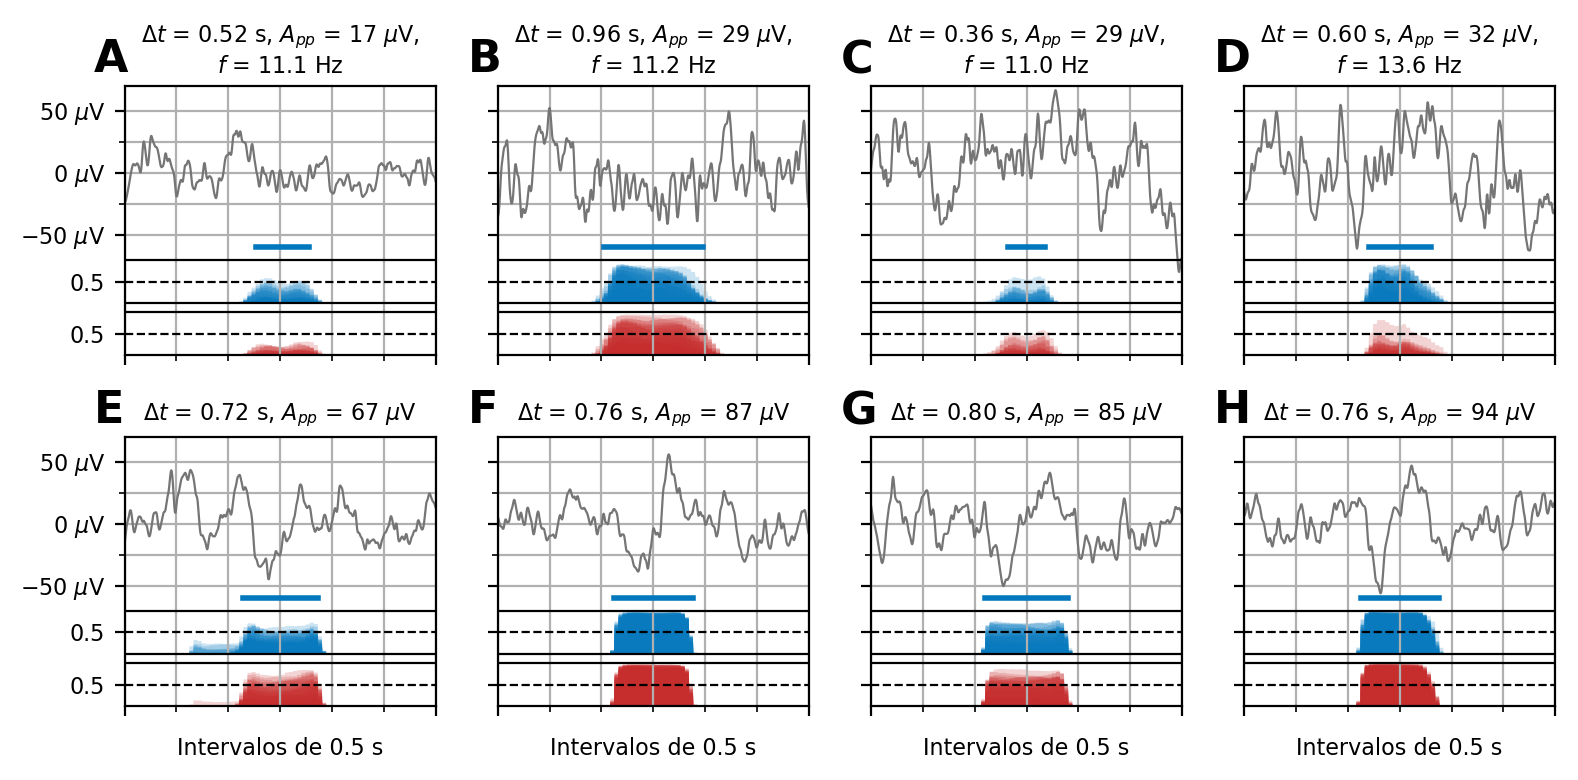

In [86]:
# plot
save_figure = True

thr_det = 0.5
thr_dur = thr_det * 0.85

alpha_proba = 0.2
letters = [['A', 'B', 'C', 'D'], ['E', 'F', 'G', 'H']]
fig, axes = plt.subplots(2, 4, figsize=(8, 4), dpi=200, sharex=True, sharey=True)

for i_config, config in enumerate(eval_configs):
    stat_spindle = (config["dataset_name"] == constants.MODA_SS_NAME)
    events_selected = ss_events_selected if stat_spindle else kc_events_selected
    for j in range(len(events_selected)):
        ax = axes[i_config, j]
        event_data = events_selected[j]
        chosen_scale = event_data['scale']
        chosen_scale_value = float(chosen_scale.split("-")[-1])
        # print(chosen_scale_value)
        chosen_subject = event_data['subject_id']
        chosen_center = event_data['center']
        start_sample = int(chosen_center - window_size // 2)
        end_sample = start_sample + window_size
        chosen_center_relative = chosen_center - start_sample
        
        # Get signal
        signal = pink.get_subject_signal(chosen_subject, normalize_clip=False)
        signal = chosen_scale_value * signal
        segment_signal = signal[start_sample:end_sample]
        
        # Get probas
        segment_proba_time = segments_list[i_config][constants.V2_TIME][j]
        segment_proba_cwt = segments_list[i_config][constants.V2_CWT1D][j]
        
        time_axis = np.arange(0, end_sample - start_sample) / pink.fs
        
        # Get OR ensemble detection at center
        det = np.stack([(p >= thr_dur).astype(np.int32) for p in segment_proba_time], axis=0).sum(axis=0)
        det = (det > 0).astype(np.int32)
        det = utils.seq2stamp(det)
        det = [d for d in det if d[0]<=chosen_center_relative<=d[1]][0]
        
        y_lim = 70
        y_gap = 0.1 * y_lim
        y_proba_width = 0.5 * y_lim
        remove_border = int(pink.fs * 1)
        
        # measure params
        event_name = constants.SPINDLE if stat_spindle else constants.KCOMPLEX
        filt_signal = param_filtering_fn(segment_signal, pink.fs, event_name)
        filt_signal_event = filt_signal[det[0]:det[1] + 1]
        event_duration = (det[1] - det[0] + 1) / pink.fs
        event_amplitude = param_amplitude_fn(filt_signal_event, pink.fs, event_name)
        if stat_spindle:
            event_frequency = param_frequency_fn(filt_signal_event, pink.fs)
        else:
            event_frequency = None
        
        # draw signal
        y_offset = 0
        ax.plot(
            time_axis[remove_border:-remove_border], 
            y_offset + segment_signal[remove_border:-remove_border],
            linewidth=0.8,
            color=viz.GREY_COLORS[6])
        ax.plot(det / pink.fs, y_offset + np.array([-y_lim * 0.85] * 2), linewidth=2, color=viz.PALETTE['blue'])
        
        # draw proba
        y_offset = y_offset - y_lim - y_proba_width
        y_offset_time = y_offset
        for proba in segment_proba_time:
            proba_segment = proba[remove_border:-remove_border]
            ax.fill_between(
                time_axis[remove_border:-remove_border], 
                y_offset, 
                y_offset + y_proba_width * proba_segment, 
                facecolor=viz.PALETTE['blue'], alpha=alpha_proba)
            
        y_offset = y_offset - y_gap - y_proba_width
        y_offset_cwt = y_offset
        for proba in segment_proba_cwt:
            proba_segment = proba[remove_border:-remove_border]
            ax.fill_between(
                time_axis[remove_border:-remove_border], 
                y_offset, 
                y_offset + y_proba_width * proba_segment, 
                facecolor=viz.PALETTE['red'], alpha=alpha_proba)

        # format
        ax.tick_params(labelsize=8)
        title_str = '$\Delta t$ = %1.2f s, $A_{pp}$ = %d $\mu$V' % (event_duration, event_amplitude)
        if stat_spindle:
            title_str = title_str + ',\n$f$ = %1.1f Hz' % (event_frequency)
        ax.set_title(title_str, fontsize=8)
        
        t0 = time_axis[remove_border]
        tf = time_axis[-remove_border]
        ax.set_xticks(np.arange(t0, tf + 0.001, 3))
        ax.set_xticks(np.arange(t0, tf + 0.001, 0.5), minor=True)
        
        # ax.axhline(y_offset_cwt, linewidth=0.8, color="k")
        ax.axhline(y_offset_cwt + y_proba_width, linewidth=0.8, color="k")
        ax.axhline(y_offset_time, linewidth=0.8, color="k")
        ax.axhline(y_offset_time + y_proba_width, linewidth=0.8, color="k")
        ax.axhline(y_offset_cwt + y_proba_width * thr_det, linewidth=0.8, color="k", linestyle="--")
        ax.axhline(y_offset_time + y_proba_width * thr_det, linewidth=0.8, color="k", linestyle="--")
        # ax.axhline(y_offset_cwt + y_proba_width * thr_dur, linewidth=0.8, color="k", linestyle="--")
        # ax.axhline(y_offset_time + y_proba_width * thr_dur, linewidth=0.8, color="k", linestyle="--")
        
        ax.set_yticks([y_offset_cwt + y_proba_width * thr_det, y_offset_time + y_proba_width * thr_det, -50, 0, 50])
        ax.set_yticklabels(['0.5', '0.5', '$-$50 $\mu$V', '0 $\mu$V', '50 $\mu$V'])
        ax.set_yticks([-50, -25, 0, 25, 50], minor=True)
        
        ax.grid(which="minor")
        ax.set_xlim([t0, tf])
        ax.set_ylim([y_offset_cwt, y_lim])
        
        if i_config == 1:
            ax.set_xticklabels([])
            ax.set_xlabel("Intervalos de 0.5 s", fontsize=8)
            
            ax.text(
                x=-0.1, y=1.05, fontsize=16, s=r"$\bf{%s}$" % letters[i_config][j],
                ha="left", transform=ax.transAxes)
        else:
            ax.text(
                x=-0.1, y=1.05, fontsize=16, s=r"$\bf{%s}$" % letters[i_config][j],
                ha="left", transform=ax.transAxes)
            
plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_indata_pink_cases"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.4)

plt.show()

#  CAP: etiquetas artificiales

- Desempeño en whole CAP-S1, CAP-S2 y CAP-A7.
- Desempeño en CAP-A7 [in-dataset] para diferentes tamaños de train (sujetos u horas por sujeto). Desempeño promedio y dispersion entre subconjuntos y entre sujetos. El conjunto de test tiene tamaño fijo.  ¿Como evolucionan las dispersiones? ¿Como evolucionan los outliers?